### Instagram

In [1]:
%pylab inline

client_id = '0db0c30814c14ac48a58c8e27a7b4a5a'
client_secret = '8681192578424d78aea183f1bf05f465'

from instagram.client import InstagramAPI
api = InstagramAPI(client_id=client_id, client_secret=client_secret)

Populating the interactive namespace from numpy and matplotlib


In [2]:
tag = 'ComeTogether'
print api.tag(tag).media_count

# get ig media based on tag

max_tag_id = 0
media_per_query = 33
MAX_ITEMS = 10000

all_media, next_ = api.tag_recent_media(media_per_query, max_tag_id, tag)

while next_:
    more_media, next_ = api.tag_recent_media(count=media_per_query, tag_name=tag, with_next_url=next_)
    all_media.extend(more_media)
        
    #print len(all_media)
    if len(all_media)>MAX_ITEMS:
        break

177262


KeyboardInterrupt: 

In [3]:
len(all_media)

7458

In [4]:
# create a dataframe and add the Instagram data we just collected
import pandas as pd

df = pd.DataFrame({
        'times':[m.created_time for m in all_media], 
        'users':[m.user.username for m in all_media]
    })

In [5]:
# since we need hourly counts, let's create a function that sets the second/minute value to zero
def make_date(d):
    d = d.replace(second=0, minute=0)
    return d

df['dt']=df[['times']].apply(lambda x: make_date(x['times']), axis=1)
ig_df = df.set_index('dt')

In [6]:
# now we have everything we need in our dataframe
ig_df.head()

,times,users
dt,,
2015-10-09 13:00:00,2015-10-09 13:09:10,eric_frampton
2015-10-09 13:00:00,2015-10-09 13:08:44,ray__kwon
2015-10-09 13:00:00,2015-10-09 13:08:41,jenannross
2015-10-09 13:00:00,2015-10-09 13:08:41,laurawannamaker
2015-10-09 13:00:00,2015-10-09 13:08:36,ctfillah88


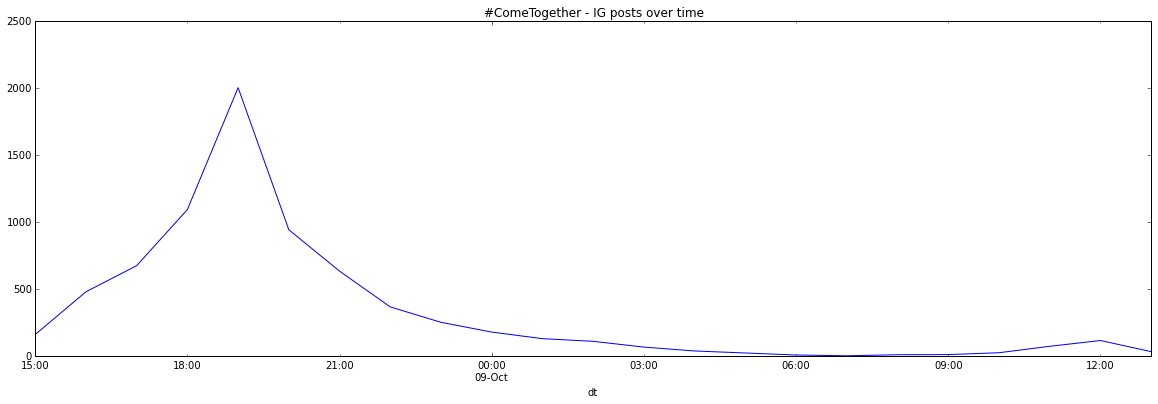

In [7]:
# let's plot it over time, group by hour, which is effectively our 'dt' column (or the index in this case)

df.groupby(df.dt).size().plot(figsize=(20,6))
title('#%s - IG posts over time' % tag)

In [ ]:
# slice only the past week -> since Twitter only lets us search back for a week
ig_df.groupby(ig_df.index).size()['2015-10-01':].plot(figsize=(20,6))

### Twitter

In [8]:
# pip install twitter
import twitter

# Twitter API keys go here
CONSUMER_KEY = 'KzLNf2VNYhdmbEeCl0E5lGAnh'
CONSUMER_SECRET = 'PRRteY7pNeAdfC73MR469IH10JkgMwIRkelvvR4eVpiYfAo3Bh'

OAUTH_TOKEN = '3183721-F6qIQaeelhdfW2ZTFRwXwJDmvSHWgvQcatqMK3DXee'
OAUTH_TOKEN_SECRET = 'Itwk1uGJM1hWQGpWSAGCchIZ5hwOZ3UsX4iGsFvTUhOcQ'


auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth)

In [9]:
count = 100

# here's how we make a basic call to twitter search -> given a query that's a hashtag
search_results = twitter_api.search.tweets(q='#'+tag, count=count)

In [11]:
search_results.keys()

[u'search_metadata', u'statuses']

In [15]:
# the results have a metadata portion which gives us all the information we need for further pagination 
search_results['search_metadata']

{u'completed_in': 0.084,
 u'count': 100,
 u'max_id': 652471632380960768,
 u'max_id_str': u'652471632380960768',
 u'next_results': u'?max_id=652470522291310591&q=%23ComeTogether&count=100&include_entities=1',
 u'query': u'%23ComeTogether',
 u'refresh_url': u'?since_id=652471632380960768&q=%23ComeTogether&include_entities=1',
 u'since_id': 0,
 u'since_id_str': u'0'}

In [16]:
# we need to parse the 'max_id' value from the 'next_results' item (in order to paginate through the next results)

def parse_twitter_next(_metadata):
    try:
        params = {a:b for a,b in [x.split('=') for x in _metadata['next_results'][1:].split('&')]}
        return int(params['max_id'])
    except:
        return None    

In [17]:
# our newly created function works!! (extracts the value of the max_id variable in the 'next_results' url)
parse_twitter_next(search_results['search_metadata'])

652470522291310591

In [18]:
# paginate through Twitter results -> GET ALL THE DATA!
num_iterations = 100

search_results = twitter_api.search.tweets(q='#'+tag, count=count)
statuses = search_results['statuses']

for i in range(num_iterations):
    max_id = parse_twitter_next(search_results['search_metadata'])   
    search_results = twitter_api.search.tweets(q='#'+tag, count=count, max_id=max_id)
    statuses += search_results['statuses']
    print len(statuses)



200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1798
1898
1998
2098
2198
2298
2398
2498
2598
2698
2798
2898
2998
3098
3198
3298
3398
3498
3596
3696
3796
3896
3996
4096
4196
4296
4396
4496
4596
4696
4796
4896
4996
5096
5196
5296
5394
5494
5594
5694
5794
5894
5994
6094
6194
6294
6394
6494
6594
6694
6794
6894
6994
7094
7192
7292
7392
7492
7592
7692
7792
7892
7992
8092
8192
8292
8392
8492
8592
8692
8792
8892
8990
9090
9190
9290
9390
9490
9590
9690
9790
9890
9990
10090


In [19]:
# create a DataFrame to hold the tweets
tw_df = pd.DataFrame({
        'times':[s['created_at'] for s in statuses], 
        'users':[s['user']['screen_name'] for s in statuses]
    })

In [20]:
tw_df.head()

,times,users
0,Fri Oct 09 13:17:33 +0000 2015,my__villa
1,Fri Oct 09 13:17:32 +0000 2015,5sos40
2,Fri Oct 09 13:17:30 +0000 2015,AustinCTV
3,Fri Oct 09 13:17:26 +0000 2015,nicolelong_
4,Fri Oct 09 13:17:25 +0000 2015,smclairmont


In [21]:
# Here its a bit more complicated - we need to parse the date string into a datetime object, which we can then
# use to set our second/minute value to zero (just like we did above for instagram)

from datetime import datetime

def make_tw_date(dt_str):
    d = datetime.strptime(dt_str, '%a %b %d %H:%M:%S +0000 %Y')
    d = d.replace(second=0, minute=0)
    return d

tw_df['dt']=tw_df[['times']].apply(lambda x: make_tw_date(x['times']), axis=1)
tw_df = tw_df.set_index('dt')

In [22]:
tw_df.head()

,times,users
dt,,
2015-10-09 13:00:00,Fri Oct 09 13:17:33 +0000 2015,my__villa
2015-10-09 13:00:00,Fri Oct 09 13:17:32 +0000 2015,5sos40
2015-10-09 13:00:00,Fri Oct 09 13:17:30 +0000 2015,AustinCTV
2015-10-09 13:00:00,Fri Oct 09 13:17:26 +0000 2015,nicolelong_
2015-10-09 13:00:00,Fri Oct 09 13:17:25 +0000 2015,smclairmont


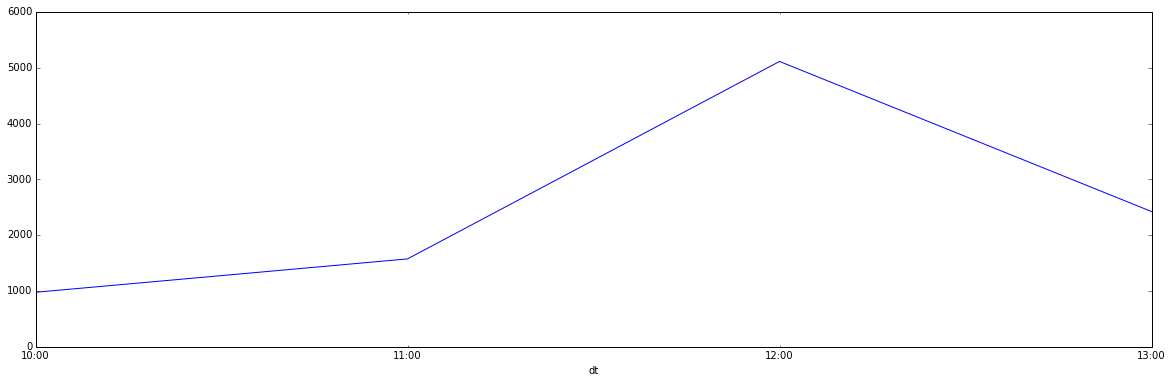

In [24]:
# slice only the past week -> since Twitter only lets us search back for a week
tw_df.groupby(tw_df.index).size().plot(figsize=(20,6))

### Merge Two DataFrames

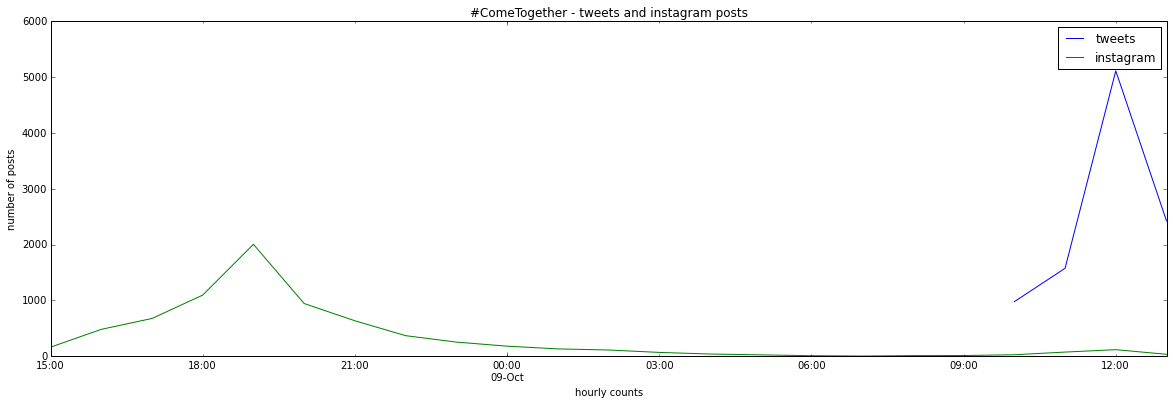

In [25]:
tw_df.groupby(tw_df.index).size().plot(figsize=(20,6), label='tweets')
ig_df.groupby(ig_df.index).size().plot(figsize=(20,6), label='instagram')
legend()
title('#%s - tweets and instagram posts' % tag)
xlabel('hourly counts')
ylabel('number of posts')